In [45]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [47]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [48]:
dir_scenario_mapping

PosixPath('/home/tony-ubuntu/decision_sciences/ssp_uganda/ssp_modeling/scenario_mapping')

In [49]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [50]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "10_fold_config.yaml")
config_params = g_utils.read_yaml(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
print("Country name: ", country_name)
print("SSP input file name: ", ssp_input_file_name)
print("SSP transformation CW: ", ssp_transformation_cw)
print("Energy model flag: ", energy_model_flag)
print("Set lndu reallocation factor to zero flag: ", set_lndu_reallocation_factor_to_zero_flag)

Country name:  uganda
SSP input file name:  ssp_inputs_uganda_10Fold_scenario.csv
SSP transformation CW:  ssp_uganda_transformation_cw_2025_04_21.xlsx
Energy model flag:  False
Set lndu reallocation factor to zero flag:  True


In [23]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

In [51]:
##  BUILD BASE INPUTS
df_inputs_raw_complete = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

## Evolution gdp_mmm_usd BaU Scenario

In [53]:
df_inputs_raw_complete = df_inputs_raw_complete.sort_values("time_period")
df_inputs_raw_complete["gdp_mmm_usd_pct_change"] = df_inputs_raw_complete["gdp_mmm_usd"].pct_change() * 100

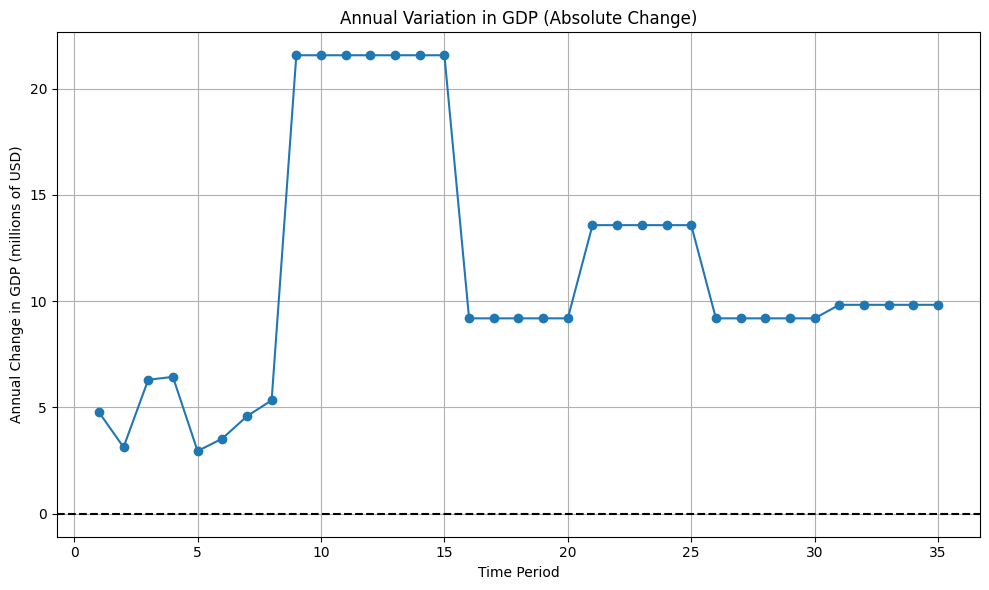

In [55]:
plt.figure(figsize=(10,6))
plt.plot(df_inputs_raw_complete["time_period"], df_inputs_raw_complete["gdp_mmm_usd_pct_change"], marker='o', linestyle='-')

plt.xlabel("Time Period")
plt.ylabel("Annual Change in GDP (millions of USD)")
plt.title("Annual Variation in GDP (Absolute Change)")
plt.axhline(0, color='black', linestyle='--')  # Línea base
plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()

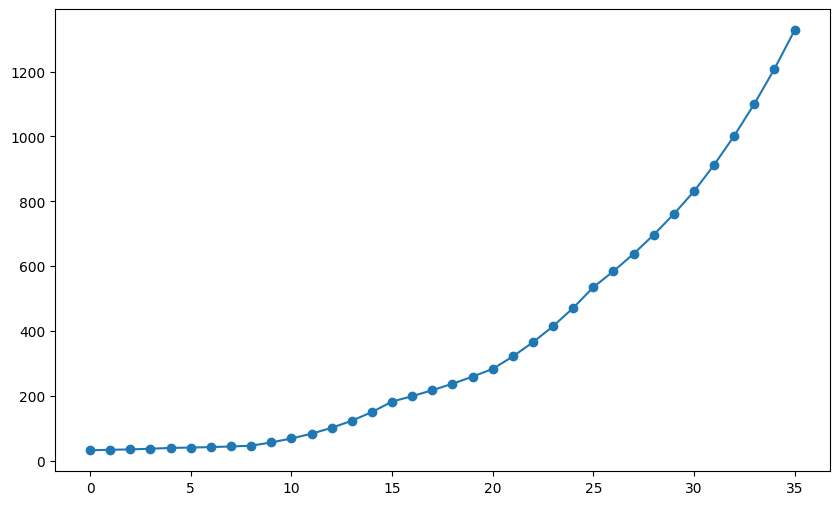

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(df_inputs_raw_complete["time_period"], df_inputs_raw_complete["gdp_mmm_usd"], marker='o')

plt.show()

#  Let's try building transformations using this


In [57]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [58]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [59]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=dir_transformations)

/home/tony-ubuntu/decision_sciences/ssp_uganda/ssp_modeling/scenario_mapping/ssp_uganda_transformation_cw_2025_04_21.xlsx


In [60]:
# This creates transformation yaml files for each strategy in the excel file
excel_yaml_handler.process_yaml_files()

Created new YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NDC and set to default because its a special case
Created new YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NZ and set to default because its a special case
Created new YAML file transformation_inen_shift_fuel_heat.yaml for strategy strategy_NZ and set to default because its a special case
Created new YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_NDC and set to default because its a special case
Created new YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_NZ and set to default because its a special case
Created new YAML file transformation_lsmm_inc_management_other.yaml for strategy strategy_NDC and set to default because its a special case
Created new YAML file transformation_lsmm_inc_management_other.yaml for strategy strategy_NZ and set to default because its a special case
C

In [61]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_NDC': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_NDC',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:ENTC:DEC_LOSSES_STRATEGY_NDC',
  'TX:ENTC:TARGET_CLEAN_HYDROGEN_STRATEGY_NDC',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_NDC',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NDC',
  'TX:IPPU:DEC_CLINKER_STRATEGY_NDC',
  'TX:IPPU:DEC_DEMAND_STRATEGY_NDC',
  'TX:IPPU:DEC_HFCS_STRATEGY_NDC',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_NDC',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_NDC',
  'TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_NDC',
  'TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_NDC',
  'TX:LVST:INC_PRODUCTIVITY_STRATEGY_NDC',
  'TX:SOIL:DEC_LIME_APPLIED_STRATEGY_NDC',
  'TX:SOIL:DEC_N_APPLIED_STRATEGY_NDC',
  'TX:TRDE:DEC_DEMAND_STRATEGY_NDC',
  'TX:TRNS:INC_EFFICIENCY_ELECTRIC_STRATEGY_NDC',
  'TX:TRN

In [62]:
transformation_per_strategy_dict.keys()

dict_keys(['strategy_NDC', 'strategy_NZ'])

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [63]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

#csv_handler.add_strategy(strategy_group='PFLO', description='NDC BaU', yaml_file_suffix='BaU')
csv_handler.add_strategy(strategy_group='PFLO', description='NDC', yaml_file_suffix='NDC')
csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')


Updated file with new row: {'strategy_id': 6003, 'strategy_code': 'PFLO:NDC', 'strategy': 'NDC', 'description': 'NDC', 'transformation_specification': 'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NDC|TX:TRNS:SHIFT_FUEL_MARITIME_STRATEGY_NDC|TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC|TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_NDC|TX:IPPU:DEC_HFCS_STRATEGY_NDC|TX:LSMM:INC_MANAGEMENT_CATTLE_PIGS_STRATEGY_NDC|TX:TRNS:SHIFT_MODE_REGIONAL_STRATEGY_NDC|TX:SOIL:DEC_N_APPLIED_STRATEGY_NDC|TX:SOIL:DEC_LIME_APPLIED_STRATEGY_NDC|TX:TRNS:SHIFT_FUEL_MEDIUM_DUTY_STRATEGY_NDC|TX:TRNS:INC_EFFICIENCY_ELECTRIC_STRATEGY_NDC|TX:WASO:INC_ENERGY_FROM_BIOGAS_STRATEGY_NDC|TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_NDC|TX:TRDE:DEC_DEMAND_STRATEGY_NDC|TX:ENTC:DEC_LOSSES_STRATEGY_NDC|TX:TRWW:INC_COMPLIANCE_SEPTIC_STRATEGY_NDC|TX:WALI:INC_TREATMENT_RURAL_STRATEGY_NDC|TX:IPPU:DEC_CLINKER_STRATEGY_NDC|TX:TRNS:SHIFT_MODE_PASSENGER_STRATEGY_NDC|TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC|TX:LNDU:INC_REFORESTATION_STRATEGY_NDC|TX:WASO:INC_CAPTURE

In [64]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004]

# Manual modification YAML

## TX:LNDU:DEC_DEFORESTATION

In [65]:

import yaml

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.999999   


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False)

  

In [66]:

with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude'] = 0.989999


with open(os.path.join(dir_transformations, 'transformation_lndu_dec_deforestation_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

## TX:AGRC:INC_CONSERVATION_AGRICULTURE

In [67]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.8
data['parameters']['magnitude_removed'] = 0.8   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NZ.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

In [68]:
with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'r') as file:
    data = yaml.safe_load(file)


data['parameters']['magnitude_burned'] = 0.6
data['parameters']['magnitude_removed'] = 0.6   


with open(os.path.join(dir_transformations, 'transformation_agrc_inc_conservation_agriculture_strategy_NDC.yaml'), 'w') as file:
    yaml.dump(data, file, sort_keys=False) 

### We finished adding new transformation files and strategies so lets load them back

In [69]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [70]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/tony-ubuntu/decision_sciences/ssp_uganda/ssp_modeling/transformations initialized in 4.08 seconds


In [71]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
66,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:NDC,NDC,NDC,TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NDC...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [72]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 6003 with input shape (36, 2261)
strat 6003 with output shape (36, 2261)
here = 6003
starting strat 6004 with input shape (36, 2261)
strat 6004 with output shape (36, 2261)
here = 6004


0

# Finally, load SISEPUEDE so that we can run it

In [73]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-04-28 16:30:36,458 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-04-28 16:30:36,461 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-04-28 16:30:36,462 - INFO - 	Setting export engine to 'csv'.
2025-04-28 16:30:36,465 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-04-28 16:30:36,465 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-04-28 16:30:36,466 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-04-28 16:30:36,466 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-04-28 16:30:36,467 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-04-28 16:30:36,467 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-04-28 16:30:36,468 - WARNING - No index fi

In [74]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-04-28 16:31:09,727 - INFO - 
***	STARTING REGION uganda	***

2025-04-28 16:31:13,722 - INFO - Trying run primary_id = 0 in region uganda
2025-04-28 16:31:13,724 - INFO - Running AFOLU model
2025-04-28 16:31:13,943 - INFO - AFOLU model run successfully completed
2025-04-28 16:31:13,944 - INFO - Running CircularEconomy model
2025-04-28 16:31:14,008 - INFO - CircularEconomy model run successfully completed
2025-04-28 16:31:14,009 - INFO - Running IPPU model
2025-04-28 16:31:14,111 - INFO - IPPU model run successfully completed
2025-04-28 16:31:14,112 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-04-28 16:31:14,135 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-04-28 16:31:14,260 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-04-28 16:31:14,261 - INFO - Running Energy (Fugitive Emissions)
2025-04-28 16:31:14,284 - E

{'uganda': [0, 69069, 70070]}

In [75]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

# Export Wide File (Last Mandatory Step)

In [76]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [77]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/tony-ubuntu/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/out'